In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

### Example: Counts of a client's previous loans

1. Get count of client's previous loans at other financial institutions


In [2]:
bureau = pd.read_csv('bureau.csv')
bureau.head()

# Columns
# SK_ID_CURR : ID of loan in our sample 
# SK_ID_BUREAU : Recoded ID of Credit Bureau credit 

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [3]:
# Groupby loan(SK_ID_CURR), 
# count the number of previous loans, and rename column

previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index = False)['SK_ID_BUREAU'].count().rename(
    columns = {'SK_ID_BUREAU' : 'previous_loan_counts'})

previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [4]:
# Join to the training dataframe
train = pd.read_csv('application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


2. Assessing usefulness of new variable with Pearson Correlation Coefficient(r-value)
- Range : -1 ~ 1
- Inspect a relationship with target using Kernal Density Estimate plot

### Kernel Density Estimate Plots
- Show distribution of single variable
- See distribution according to the category(Target = 0 or 1)
- This can serve as an indicator of whether variable is relevant or not

In [5]:
# Plots the distribution of a variable colored by value of the target

def kde_target(var_name, df) :
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0, and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # Label the plot
    # Use of ; : Suppress the output of that command from being displayed
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # Print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' 
          % (var_name, corr))
    
    # Print out average values depending on repayment
    print('Median value for loan that was not repaid = %0.4f'
          % avg_not_repaid)
    print('Median value for loan that was repaid = %0.4f'
          % avg_repaid)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid = 0.5460


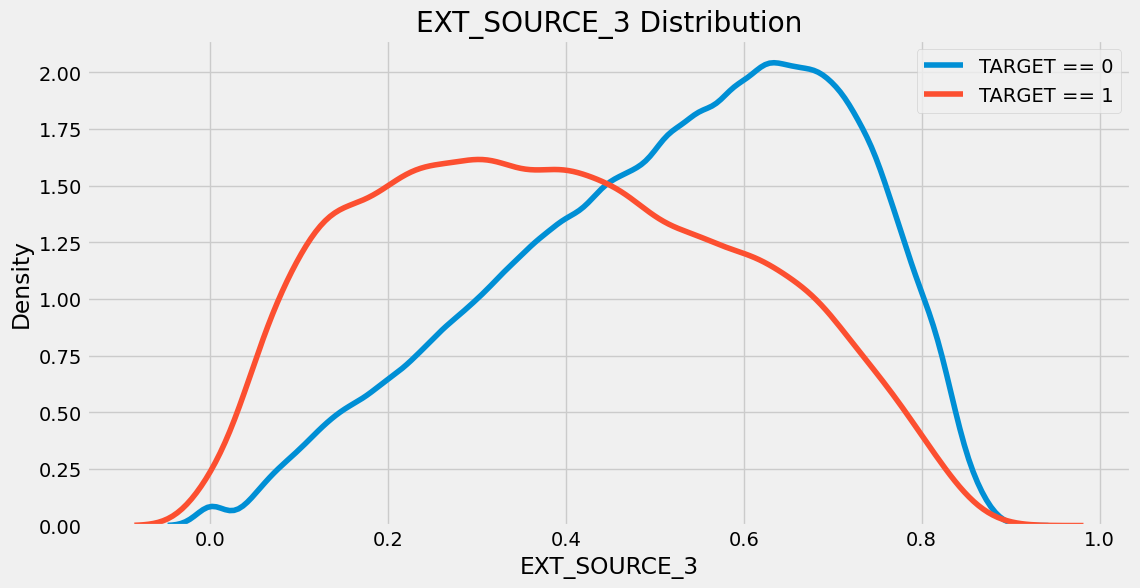

In [6]:
# Test with variable EXT_SOURCE_3

kde_target('EXT_SOURCE_3', train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid = 4.0000


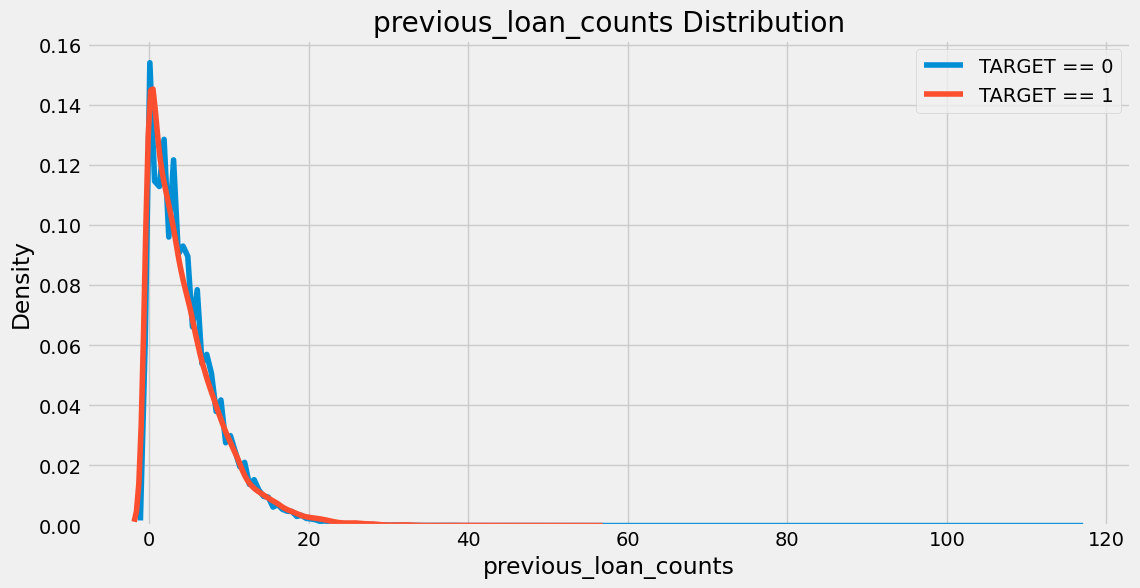

In [7]:
# Test with variable previous_loan_counts

kde_target('previous_loan_counts', train)

- Correlation coefficient -0.01 extremely weak
- Also no noticeable difference in dist

### Aggregating Numeric Columns
- Compute statistics for all numeric columns
- Using function 'agg' and 'groupby'

In [8]:
# Group by client id, calculate aggregation stats
# Numeric error -> 코드 수정

# Drop the 'SK_ID_BUREAU' column
bureau_agg_1 = bureau.drop(columns=['SK_ID_BUREAU'])

# Identify numeric columns
numeric_cols = bureau_agg_1.select_dtypes(include=['number']).columns.tolist()

# Apply aggregations only on numeric columns, then merge with non-numeric using 'count' for example
bureau_agg = bureau_agg_1.groupby('SK_ID_CURR', as_index=False)[numeric_cols].agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

# bureau_agg = bureau.drop(columns=['SK_ID_CURR'])
bureau_agg.head()

SK_ID_CURR                                         DAYS_CREDIT               \
             count      mean     max     min     sum       count         mean   
0     100001     7  100001.0  100001  100001  700007           7  -735.000000   
1     100002     8  100002.0  100002  100002  800016           8  -874.000000   
2     100003     4  100003.0  100003  100003  400012           4 -1400.750000   
3     100004     2  100004.0  100004  100004  200008           2  -867.000000   
4     100005     3  100005.0  100005  100005  300015           3  -190.666667   

              ... DAYS_CREDIT_UPDATE                              AMT_ANNUITY  \
   max   min  ...              count        mean  max   min   sum       count   
0  -49 -1572  ...                  7  -93.142857   -6  -155  -652           7   
1 -103 -1437  ...                  8 -499.875000   -7 -1185 -3999           7   
2 -606 -2586  ...                  4 -816.000000  -43 -2131 -3264           0   
3 -408 -1326  ...                  2 -532.000000 -382  -682 -1064           0   
4  -62  -373  ...                  3  -54.333333  -11  -121  -163           3   

                                       
          mean      max  min      sum  
0  3545.357143  10822.5  0.0  24817.5  
1     0.000000      0.0  0.0      0.0  
2          NaN      NaN  NaN      0.0  
3          NaN      NaN  NaN      0.0  
4  1420.500000   4261.5  0.0   4261.5  

[5 rows x 66 columns]

In [9]:
# kaggle과 똑같이 만들어주기 위함
res = bureau_agg.drop(columns = [('SK_ID_CURR', 'count'),
                                ('SK_ID_CURR', 'mean'),
                                ('SK_ID_CURR', 'max'),
                                ('SK_ID_CURR', 'min'),
                                ('SK_ID_CURR', 'sum')])
res

SK_ID_CURR DAYS_CREDIT                                  \
                        count         mean   max   min    sum   
0          100001           7  -735.000000   -49 -1572  -5145   
1          100002           8  -874.000000  -103 -1437  -6992   
2          100003           4 -1400.750000  -606 -2586  -5603   
3          100004           2  -867.000000  -408 -1326  -1734   
4          100005           3  -190.666667   -62  -373   -572   
...           ...         ...          ...   ...   ...    ...   
305806     456249          13 -1667.076923  -483 -2713 -21672   
305807     456250           3  -862.000000  -760 -1002  -2586   
305808     456253           4  -867.500000  -713  -919  -3470   
305809     456254           1 -1104.000000 -1104 -1104  -1104   
305810     456255          11 -1089.454545  -363 -2337 -11984   

       CREDIT_DAY_OVERDUE               ... DAYS_CREDIT_UPDATE               \
                    count mean max min  ...              count         mean   
0                       7  0.0   0   0  ...                  7   -93.142857   
1                       8  0.0   0   0  ...                  8  -499.875000   
2                       4  0.0   0   0  ...                  4  -816.000000   
3                       2  0.0   0   0  ...                  2  -532.000000   
4                       3  0.0   0   0  ...                  3   -54.333333   
...                   ...  ...  ..  ..  ...                ...          ...   
305806                 13  0.0   0   0  ...                 13 -1064.538462   
305807                  3  0.0   0   0  ...                  3   -60.333333   
305808                  4  0.0   0   0  ...                  4  -253.250000   
305809                  1  0.0   0   0  ...                  1  -401.000000   
305810                 11  0.0   0   0  ...                 11  -531.090909   

                         AMT_ANNUITY                                      \
        max   min    sum       count           mean       max        min   
0        -6  -155   -652           7    3545.357143   10822.5      0.000   
1        -7 -1185  -3999           7       0.000000       0.0      0.000   
2       -43 -2131  -3264           0            NaN       NaN        NaN   
3      -382  -682  -1064           0            NaN       NaN        NaN   
4       -11  -121   -163           3    1420.500000    4261.5      0.000   
...     ...   ...    ...         ...            ...       ...        ...   
305806  -12 -2498 -13839           0            NaN       NaN        NaN   
305807  -23  -127   -181           3  154567.965000  384147.0  27757.395   
305808   -5  -701  -1013           3   58369.500000   58369.5  58369.500   
305809 -401  -401   -401           1       0.000000       0.0      0.000   
305810   -8 -1621  -5842           9    1081.500000    3244.5      0.000   

                    
               sum  
0        24817.500  
1            0.000  
2            0.000  
3            0.000  
4         4261.500  
...            ...  
305806       0.000  
305807  463703.895  
305808  175108.500  
305809       0.000  
305810    9733.500  

[305811 rows x 61 columns]

In [10]:
bureau_agg = res
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

In [11]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variable names
for var in bureau_agg.columns.levels[0] :
    
    # Skip the id name
    if var != 'SK_ID_CURR' :
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1] :
            
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [12]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [13]:
# Merge with the training data
# 더 정보가 많음
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


In [14]:
# Correlation of Aggregated values with Target

# List of new correlations
new_corrs = []

# Iterate through the columns of bureau data
for col in columns :
    
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple
    new_corrs.append((col, corr))

In [15]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of the list
new_corrs = sorted(new_corrs, key = lambda x : abs(x[1]), reverse = True)

new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.0897289672199812),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010363),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968675),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392069),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102053),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.053199625857586044),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997304),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111593),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483544),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073016),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484673),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.041403635353060055),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632906),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325522)]

- Top 15 significant correlation with TARGET

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid = -1067.0000


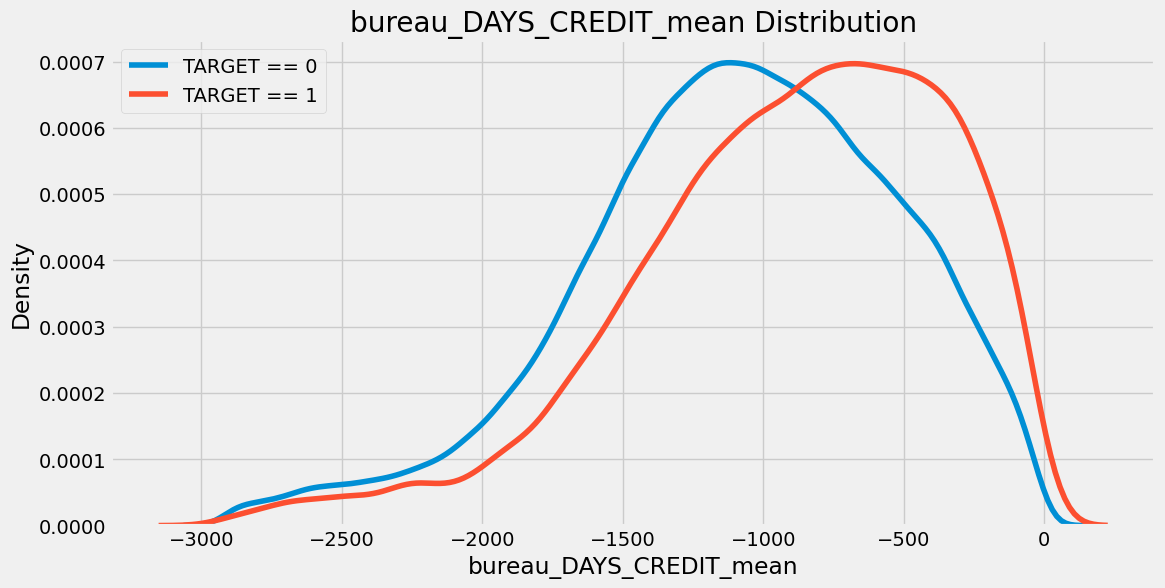

In [16]:
kde_target('bureau_DAYS_CREDIT_mean', train)

- Client who applied for loans further in the past are more likely to repay loans at Home Credit
- But the correlation is still weak

### Function of Numeric Aggregations
- Compute aggregate stats for numeric columns

In [17]:
def agg_numeric(df, group_var, df_name) :
    # group_var : variable to group dataframe
    # df_name : variable used to rename the columns
    
    # Remove id variables other that grouping variable
    for col in df :
        if col != group_var and 'SK_ID' in col :
            df = df.drop(columns = col)
    
    group_ids = df[group_var] # 그룹핑할 컬럼 지정
    numeric_df = df.select_dtypes('number') # 뉴메릭만 뽑고
    numeric_df[group_var] = group_ids # 그룹핑 컬럼 붙이기
    
    # Group gy specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean',
                                            'max', 'min', 'sum']).reset_index()
    
    # Need to create new column names
    columns = [group_var]
    
    # Iterate through the variables names
    for var in agg.columns.levels[0] :
        
        # Skip the grouping variable
        if var != group_var :
            
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                
                # Make a new column name for variable and stat
                columns.append('%s_%s_%s' %(df_name, var, stat))
    
    agg.columns = columns
    
    return agg

In [18]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']),
                            group_var = 'SK_ID_CURR', df_name = 'bureau')

bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [19]:
# 손으로 만든 것과, 함수 쓴 것 비교하기
bureau_agg.head()

# 같은 결과

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [20]:
# Correlation Function
# Function to calculate correlations with the target for a dataframe

def target_corrs(df) :
    # List of correlations
    corrs = []
    
    # Iterate through the columns
    for col in df.columns :
        print(col)
        
        # Skip the target column
        if col != 'TARGET' :
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])
    
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

### Categorial Variables
- Calclate value counts of each category
- One-hot encoding for categorical columns

In [21]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
1,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
2,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
3,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
4,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354


In [22]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

- Sum col : Count of category for associated clients
- Mean col : Normalized count

In [23]:
# 카테고리 변수들 확인
categorical_grouped.columns.levels[0]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan',
       'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
       'CREDIT_TYPE_Loan for the purchase of equipment',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan',
       'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_Real estate loan',
       'CREDIT_TYPE_Unknown type of loan'],
      dtype='object')

In [24]:
# 통계량 확인
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [25]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0] :
    
    # Skip the grouping variable
    if var != group_var :
        
        # Iterate through the stat names
        for stat in ['count', 'count_norm'] :
            
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

# Rename the columns
categorical_grouped.columns = columns

categorical_grouped

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,2,0.153846,0,0.0,11,0.846154,0,0.0,13,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
456250,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
456253,2,0.500000,0,0.0,2,0.500000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [26]:
# Merge to training data
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')

train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train.shape

(307511, 229)

In [28]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Function to Handle Categorical Variables
- Calculate the counts and normalized counts of each category

In [29]:
# 데이터 프레임 받으면 카운트랑, 평균 도출하는 함수

def count_categorical(df, group_var, df_name):
    # group_var : variable to group the dataframe
    # df_name : string, variable added to the front of column names
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))
    
    # Make sur to put the identifying id on the column
    categorical[group_var] = df[group_var]
    
    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0] :
        
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm'] :
            
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [30]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')

bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [31]:
# Bureau balance dataframe
bureau_balance = pd.read_csv('bureau_balance.csv')

bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [32]:
# Categorical variable
# Calculate the value counts of each status for each loan(SK_ID_BUREAU)

bureau_balance_counts = count_categorical(bureau_balance, 
                                         group_var = 'SK_ID_BUREAU',
                                         df_name = 'bureau_balance')

bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [33]:
# Numeric variable 
# Months_Balance : Months of balance relative to application date
# Calculate the value counts for each loan(SK_ID_BUREAU)

bureau_balance_agg = agg_numeric(bureau_balance, 
                                 group_var = 'SK_ID_BUREAU',
                                df_name = 'bureau_balance')

bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [34]:
# Above dataframes are calculated on each loan
# Now aggregate for each client

# Dataframe grouped by the loan 합쳐
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts,
                                         right_index = True,
                                         left_on = 'SK_ID_BUREAU',
                                         how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']],
                                     on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [35]:
# Numeric 밖에 없기 때문에 agg_numeric만 해도 가능
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']),
                                      group_var = 'SK_ID_CURR', df_name = 'client')

bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41,4,0.254545,1.000000,0.0,1.018182


### Putting the Functions Together
- Put them into main training dataframe

In [36]:
import gc
gc.enable() # Garbage collection 활성화
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan,bureau_balance_by_client, bureau_counts
gc.collect() # Garbage collection 실행하여 더 이상 사용되지 않는 객체 메모리 회수

356

In [37]:
# Read in new copies of all the dataframes
train = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')

In [38]:
# Categorical
# Counts of Bureau Dataframe
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR',
                                 df_name = 'bureau')

bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [39]:
# Numeric
# Aggregated Status of Bureau Dataframe
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']),
                        group_var = 'SK_ID_CURR', df_name = 'bureau')

bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [40]:
# Categorical
# Value counts of Bureau Balance Dataframe by loan
bureau_balance_counts = count_categorical(bureau_balance,
                                         group_var = 'SK_ID_BUREAU',
                                         df_name = 'bureau_balance')

bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [41]:
# Numeric
# Aggregated Stats of Bureau Dataframe by loan
bureau_balance_agg = agg_numeric(bureau_balance, 
                                 group_var = 'SK_ID_BUREAU',
                                df_name = 'bureau_balance')

bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [42]:
# Aggregated Status of Bureau Balance by Client

# Merge Categorical and Numeric
# Dataframe grouped by loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts,
                                         right_index = True,
                                         left_on = 'SK_ID_BUREAU',
                                         how = 'outer')

# Add SK_ID_CURR, SK_ID_BUREAU (Loan info)
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan,
                                                             on = 'SK_ID_BUREAU',
                                                             how = 'left')

# Aggregate the stats for each client
# Balance 두번째 정보를 합친 것을 client loan 별로 group by
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']),
                                      group_var = 'SK_ID_CURR', df_name = 'client')

In [43]:
# Insert Computed Features into Training Data

# Check how many features
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [44]:
# Merge with the value counts of bureau(Categorical)
# By client loan, 첫번째 정보 합친 것
train = train.merge(bureau_counts, on = 'SK_ID_CURR',
                   how = 'left')

# Merge with the stats of bureau(Numeric)
train = train.merge(bureau_agg, on = 'SK_ID_CURR',
                   how = 'left')

# Merge with the monthly information grouped by client
# 두번째 정보도 넣음
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR',
                   how = 'left')

In [45]:
# Check how many features now
new_features = list(train.columns)
print('Number of features using previous loans from other in stitutions data: ',
     len(new_features))

Number of features using previous loans from other in stitutions data:  333


### Feature Engineering Outcomes
- Look at the variables we have created
- Check percentage of missing values, correlations of var w target, and w other var
- Leading to Feature Selection, to prevent "Curse of Dimensionality"

In [46]:
# Missing Values

# Function to calculate missing values by column Function
def missing_values_table(df) :
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
    '% of Total Values', ascending = False).round(1)
    
    # Print some summary info
    print('Your selected dataframe has ' + str(df.shape[1]) + 
         'columns.\n'
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
         ' columns that have missing values.')
    
    # Return the dataframe with missing info
    return mis_val_table_ren_columns

In [47]:
missing_train = missing_values_table(train)

missing_train.head(10)

Your selected dataframe has 333columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


In [48]:
# 90% 이상 missing values vars 삭제
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])

len(missing_train_vars)

0

In [49]:
# Testing Data 정보 정리한 후, missing values 삭제
# Calculating Info from testing data

# Read in the test df
test = pd.read_csv("application_test.csv")

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR',
                 how = 'left')

In [50]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


In [51]:
# Align the testing and training dataframes
# Making sure they have same columns

train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [52]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape) # TARGET만 없음

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [53]:
# Check Missing Values
missing_test = missing_values_table(test)

missing_test.head(10)

Your selected dataframe has 332columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [54]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])

len(missing_test_vars)

0

In [55]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print("There are %d columns with more that 90%% missing in either the training or testing data." % len(missing_columns))

There are 0 columns with more that 90% missing in either the training or testing data.


In [56]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [57]:
# Save
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

In [58]:
# 원-핫 인코딩 train
train_encoded = pd.get_dummies(train)
train_encoded

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,False,False,False,False,False,False,True,False,True,False
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,False,True,False,False,False,False,False,False,True,False
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,...,False,False,False,False,False,False,True,False,True,False
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,...,False,False,False,False,False,False,True,False,True,False
307508,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,...,False,False,False,False,False,True,False,False,True,False
307509,456254,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,...,False,False,False,False,False,False,True,False,True,False


In [59]:
# 원-핫 인코딩 test
test_encoded = pd.get_dummies(test)
test_encoded

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,False,False,False,False,False,False,True,False,True,False
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,False,False,False,False,False,False,False,False,False,False
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,False,False,False,False,False,False,False,False,False,False
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,False,False,False,False,False,True,False,False,True,False
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,121500.0,412560.0,17473.5,270000.0,0.002042,-19970,-5169,-9094.0,...,False,False,False,False,False,False,False,False,False,False
48740,456222,2,157500.0,622413.0,31909.5,495000.0,0.035792,-11186,-1149,-3015.0,...,False,False,False,False,False,False,False,False,False,False
48741,456223,1,202500.0,315000.0,33205.5,315000.0,0.026392,-15922,-3037,-2681.0,...,False,False,False,False,False,False,True,False,True,False
48742,456224,0,225000.0,450000.0,25128.0,450000.0,0.018850,-13968,-2731,-1461.0,...,False,False,False,False,False,True,False,False,True,False


In [60]:
# Correlations of the vars with the TARGET
# Calculate all correlations in dataframe
corrs = train_encoded.corr()

In [61]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive corrlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [62]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))
###########

,TARGET
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
NAME_EDUCATION_TYPE_Higher education,-0.056593
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid = 0.3636


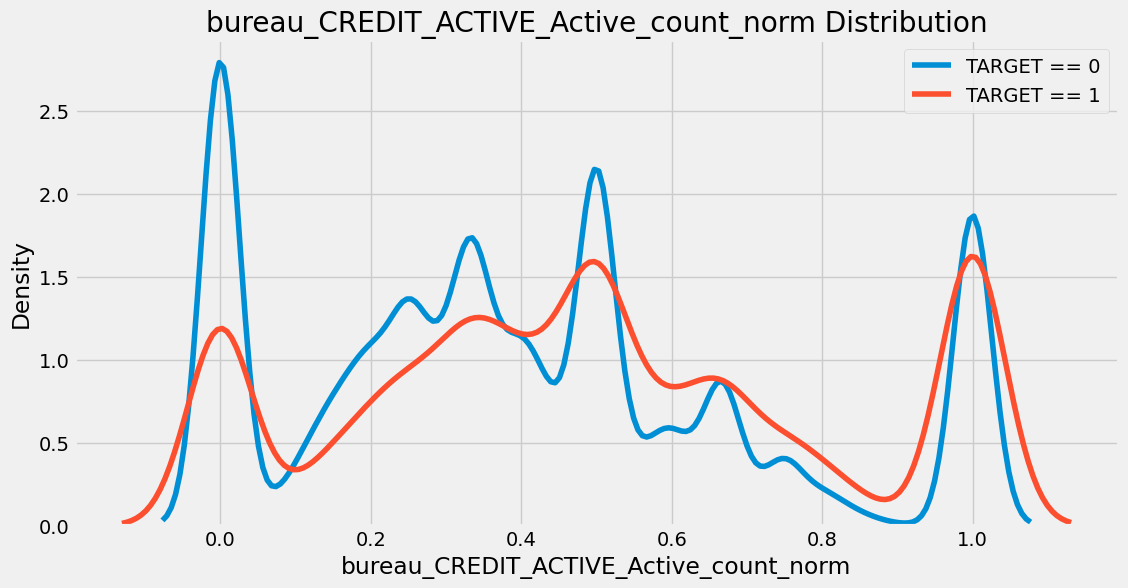

In [63]:
kde_target(var_name = 'bureau_CREDIT_ACTIVE_Active_count_norm', df = train_encoded)

# Correlation so weak

### Collinear Variables
- Correlation of each variable with every other variable
- Will there any correlation greather than 0.8?

In [64]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [65]:
train_encoded
# 더미 베리어블로 만들어서 457개로 증가

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,False,False,False,False,False,False,True,False,True,False
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,False,True,False,False,False,False,False,False,True,False
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,...,False,False,False,False,False,False,True,False,True,False
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,...,False,False,False,False,False,False,True,False,True,False
307508,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,...,False,False,False,False,False,True,False,False,True,False
307509,456254,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,...,False,False,False,False,False,False,True,False,True,False


In [66]:
corrs

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
TARGET,-0.002108,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,0.041975,...,0.000982,-0.006777,-0.001713,-0.009384,0.000628,-0.033119,-0.012657,0.007946,-0.042201,0.004829
bureau_DAYS_CREDIT_mean,0.003636,0.026094,-0.008837,-0.084393,-0.066503,-0.086089,-0.019976,0.203135,-0.043686,0.096894,...,0.001475,-0.009561,-0.001871,-0.002788,-0.002990,-0.033748,-0.019226,0.006393,-0.046714,0.005324
client_bureau_balance_MONTHS_BALANCE_min_mean,0.003236,0.021236,-0.025563,-0.083456,-0.058436,-0.085685,-0.013693,0.200788,-0.041321,0.091993,...,-0.000954,-0.013407,0.001875,-0.005822,0.000250,-0.031003,-0.014342,0.000449,-0.044446,0.003926
DAYS_BIRTH,-0.001500,0.330938,0.027261,-0.055436,0.009445,-0.053442,-0.029582,1.000000,-0.615864,0.331912,...,0.000388,-0.006749,-0.000262,0.004421,-0.000690,-0.013597,-0.010964,0.008758,-0.019852,0.005434
bureau_CREDIT_ACTIVE_Active_count_norm,0.001229,0.013221,0.016527,-0.021280,-0.037859,-0.026544,0.015857,0.116114,-0.049473,0.046167,...,-0.001177,-0.004521,-0.002513,0.001285,-0.001989,-0.014775,-0.009845,0.002615,-0.023222,0.000262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.000463,-0.013071,-0.016815,0.021459,0.037671,0.026702,-0.017241,-0.115926,0.050521,-0.046846,...,0.001068,0.004790,0.002695,-0.001259,0.001808,0.013862,0.009900,-0.002770,0.022736,-0.000274
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.004068,-0.026412,0.023685,0.071355,0.071230,0.073737,0.027155,-0.160568,0.033628,-0.076290,...,0.003214,0.010371,0.001183,0.006998,-0.003291,0.027524,0.014146,-0.002395,0.039385,-0.007459
EXT_SOURCE_1,0.000082,-0.138470,0.026232,0.168429,0.119398,0.175502,0.099997,-0.600610,0.289848,-0.181095,...,-0.000884,0.020686,0.012625,0.028323,0.006205,0.054344,0.042046,-0.013226,0.098057,-0.013839
EXT_SOURCE_2,0.002342,-0.018015,0.060925,0.131228,0.125804,0.139367,0.198924,-0.091996,-0.020767,-0.059913,...,0.000840,0.015538,0.009503,0.029676,0.006843,0.075801,0.063222,-0.020118,0.127258,-0.008632


In [67]:
above_threshold_vars
# 상관관계가 0.8이 넘는 변수들이 value에 저장

{'SK_ID_CURR': ['SK_ID_CURR'],
 'CNT_CHILDREN': ['CNT_CHILDREN', 'CNT_FAM_MEMBERS'],
 'AMT_INCOME_TOTAL': ['AMT_INCOME_TOTAL'],
 'AMT_CREDIT': ['AMT_CREDIT', 'AMT_GOODS_PRICE'],
 'AMT_ANNUITY': ['AMT_ANNUITY'],
 'AMT_GOODS_PRICE': ['AMT_CREDIT', 'AMT_GOODS_PRICE'],
 'REGION_POPULATION_RELATIVE': ['REGION_POPULATION_RELATIVE'],
 'DAYS_BIRTH': ['DAYS_BIRTH'],
 'DAYS_EMPLOYED': ['DAYS_EMPLOYED',
  'ORGANIZATION_TYPE_XNA',
  'NAME_INCOME_TYPE_Pensioner'],
 'DAYS_REGISTRATION': ['DAYS_REGISTRATION'],
 'DAYS_ID_PUBLISH': ['DAYS_ID_PUBLISH'],
 'OWN_CAR_AGE': ['OWN_CAR_AGE'],
 'FLAG_MOBIL': ['FLAG_MOBIL'],
 'FLAG_EMP_PHONE': ['FLAG_EMP_PHONE'],
 'FLAG_WORK_PHONE': ['FLAG_WORK_PHONE'],
 'FLAG_CONT_MOBILE': ['FLAG_CONT_MOBILE'],
 'FLAG_PHONE': ['FLAG_PHONE'],
 'FLAG_EMAIL': ['FLAG_EMAIL'],
 'CNT_FAM_MEMBERS': ['CNT_CHILDREN', 'CNT_FAM_MEMBERS'],
 'REGION_RATING_CLIENT': ['REGION_RATING_CLIENT_W_CITY',
  'REGION_RATING_CLIENT'],
 'REGION_RATING_CLIENT_W_CITY': ['REGION_RATING_CLIENT_W_CITY',
  'R

In [68]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items() :
    # Keep track of columns already examined
    cols_seen.append(key)
    
    for x in value :
        if x == key :
            next # 자기자신 이므로 1.0
        else :
            # Only want to remove one in a pair, 반대의 경우 2쌍이므로
            if x not in cols_seen :
                cols_to_remove.append(x) # value 넣고
                cols_to_remove_pair.append(key) # key 넣고
                
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

# 변수들끼리 상관관계가 있으면 노이즈를 발생시키기 때문에 제거해주는 것이 좋음

Number of columns to remove:  137


In [69]:
train_corrs_removed = train_encoded.drop(columns = cols_to_remove)
test_corrs_removed = test_encoded.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 320)
Testing Corrs Removed Shape:  (48744, 316)


In [70]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

### Modeling
##### Hyperparameters
- Control : Only the data in application files
- Test one : Data from application files recorded from bureau, and bureau_balance files
- Test two : Test one, highly correlated variables removed

In [71]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [72]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    # encoding = 'ohe' : method for encoding categorical var
    # n_folds : cross validation
    
    # return
    # submission : df with probablilities predicted by model
    # feature_importances
    # valid_metrics : df with training and validation metrics(ROC AUC) for each fold
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        # 카테고리 변수를 인식하게끔
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices)
                  #early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics


In [73]:
def plot_feature_importances(df) :
    # df : feature importances
    
    # Return
    # df : 15 most importance features
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized']  = df['importance'] / df['importances'].sum()
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reserve the index to plot the most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()
    
    return df

## Control

In [74]:
train_control = pd.read_csv('application_train.csv')
test_control = pd.read_csv('application_test.csv')

In [ ]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)


In [ ]:
metrics

### Results_Control
- Control slightly overfits because training score is higher than valid score

In [ ]:
fi_sorted = plot_feature_importances(fi)

### Final Results
- Compare auc of fold, train, valid among control, test one, test two